In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import os
from xml.dom import minidom
import cv2
import glob

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
file_path = '/content/drive/MyDrive/obj_detection/training_images/cucumber_1.xml'
obj = minidom.parse(file_path)

width = obj.getElementsByTagName('width')
int(width[0].firstChild.nodeValue)

227

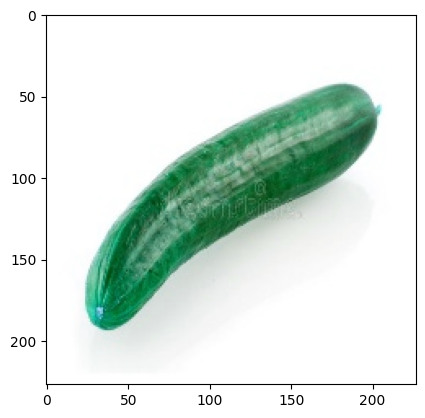

In [20]:
img = cv2.imread('/content/drive/MyDrive/obj_detection/training_images/cucumber_1.jpg',cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [21]:
def get_value(obj,name) :
    a = int(obj.getElementsByTagName(name)[0].firstChild.nodeValue)
    return a

In [22]:
xmin = get_value(obj,'xmin')
ymin = get_value(obj,'ymin')
xmax = get_value(obj,'xmax')
ymax = get_value(obj,'ymax')
width = get_value(obj,'width')
height = get_value(obj,'height')

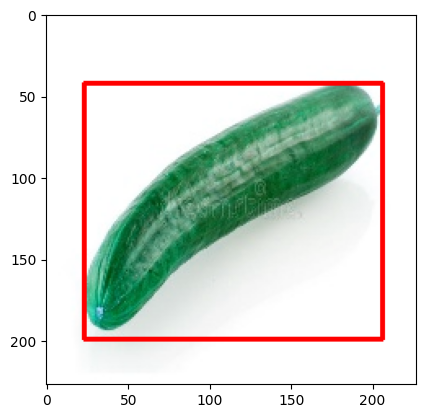

In [23]:
bnd_img = cv2.rectangle(img,(xmin,ymin),(xmax,ymax),(255,0,0),2)
plt.imshow(bnd_img)

In [24]:
def load_img(path) :
    X = []
    for i in sorted(glob.glob(path)) :
        img = cv2.imread(i,cv2.COLOR_BGR2RGB)
        X.append(img)
    return np.asarray(X)

In [25]:
def load_xml(path) :
    y = []
    for i in sorted(glob.glob(path)) :
        c = 0
        obj = minidom.parse(i)
        folder = obj.getElementsByTagName('folder')[0].firstChild.nodeValue
        width = get_value(obj,'width')
        height = get_value(obj,'height')
        xmin = get_value(obj,'xmin')
        ymin = get_value(obj,'ymin')
        xmax = get_value(obj,'xmax')
        ymax = get_value(obj,'ymax')
        if "cucumber" in folder :
            c = 1
        elif "eggplant" in folder :
            c = 2
        elif "mushroom" in folder :
            c = 3
        y.append([c,xmin,ymin,xmax,ymax])
    return np.asarray(y)

In [26]:
X = load_img('/content/drive/MyDrive/obj_detection/training_images/*.jpg')
X.shape

(186, 227, 227, 3)

In [27]:
Y = load_xml('/content/drive/MyDrive/obj_detection/training_images/*.xml')
Y.shape

(186, 5)

In [91]:
import random

In [ ]:
from sklearn.model_selection import train_test_split

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size=0.2)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((148, 227, 227, 3), (148, 5), (38, 227, 227, 3), (38, 5))

In [49]:
train_label = y_train[:,0:1]
test_label = y_test[:,0:1]
train_bbox = y_train[:,1:]
test_bbox = y_test[:,1:]

print(f"Train label shape: {train_label.shape}")
print(f"Test label shape: {test_label.shape}")
print(f"Train box shape: {train_bbox.shape}")
print(f"Test box shape: {test_bbox.shape}")

Train label shape: (148, 1)
Test label shape: (38, 1)
Train box shape: (148, 4)
Test box shape: (38, 4)


In [82]:
categ_train = tf.keras.utils.to_categorical(train_label)
categ_test = tf.keras.utils.to_categorical(test_label)

In [97]:
model = tf.keras.applications.EfficientNetB1(
    weights='imagenet',
    include_top=False,
    input_shape=(227,227,3)
    )

for layer in model.layers:
        layer.trainable = False

In [98]:
from tensorflow.keras.layers import Flatten, Dense, Dropout

In [99]:
dl1 = Flatten()(model.output)
dol1 = Dropout(0.3)(dl1)

dl2 = Dense(512, activation='relu')(dol1)
dol2 = Dropout(0.3)(dl2)

dl3 = Dense(256, activation='relu')(dol2)
dol3 = Dropout(0.3)(dl3)

dl4 = Dense(128, activation='relu')(dol3)

label_output = Dense(4, activation='softmax', name='classification_task')(dl2)
bbox_output = Dense(4, name="regression_task")(dl4)

model = Model(inputs = [model.input], outputs=[label_output, bbox_output])

In [100]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 227, 227, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_4 (Rescaling)        (None, 227, 227, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_2 (Normalization  (None, 227, 227, 3)  7          ['rescaling_4[0][0]']            
 )                                                                                                
                                                                                            

In [101]:
model.compile(optimizer=Adam(learning_rate=1e-4),
             loss={'classification_task': 'categorical_crossentropy',
                  'regression_task':'mse'},
             metrics = {
                'classification_task':'accuracy',
                'regression_task':'mse'
             })

In [104]:
history = model.fit(X_train, [categ_train, train_bbox], epochs=20, validation_data=(X_test, [categ_test, test_bbox]))

Epoch 1/20
5/5 [==============================] - 34s 7s/step - loss: 11761.6045 - classification_task_loss: 5.9859 - regression_task_loss: 11755.6201 - classification_task_accuracy: 0.3243 - regression_task_mse: 11755.6201 - val_loss: 6757.1470 - val_classification_task_loss: 7.2209 - val_regression_task_loss: 6749.9258 - val_classification_task_accuracy: 0.3421 - val_regression_task_mse: 6749.9258
Epoch 2/20
5/5 [==============================] - 31s 7s/step - loss: 5861.8320 - classification_task_loss: 7.3593 - regression_task_loss: 5854.4727 - classification_task_accuracy: 0.3514 - regression_task_mse: 5854.4727 - val_loss: 2401.6687 - val_classification_task_loss: 7.7563 - val_regression_task_loss: 2393.9126 - val_classification_task_accuracy: 0.4474 - val_regression_task_mse: 2393.9126
Epoch 3/20
5/5 [==============================] - 26s 5s/step - loss: 2692.6836 - classification_task_loss: 8.9548 - regression_task_loss: 2683.7290 - classification_task_accuracy: 0.3514 - regress

In [109]:
def prediction(image_path, model):

    image = cv2.imread(image_path)
    image = cv2.resize(image,(227,227))
    label, bbox = model.predict([np.array([image])])
    label = np.argmax(label)
    bbox = bbox.flatten().astype(int)
    image = cv2.rectangle(image, (bbox[0], bbox[1]), (bbox[2], bbox[3]), color=(0,0,255), thickness=1)
    prediction = ""
    if label == 1:
        prediction = 'cucumber'
    elif label == 2:
        prediction = 'Egg plant'
    elif label == 3:
        prediction = 'Mushroom'

    image = cv2.putText(image, prediction, (bbox[0], bbox[1]-4), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0,0,255), 1, 255)
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

1/1 [==============================] - 0s 461ms/step


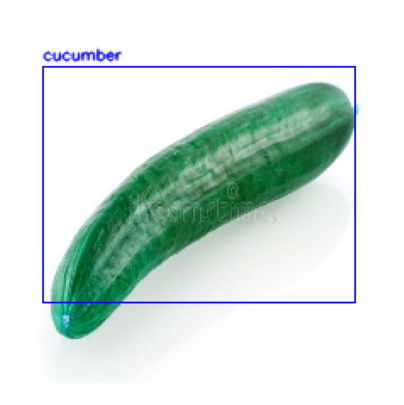

1/1 [==============================] - 0s 211ms/step


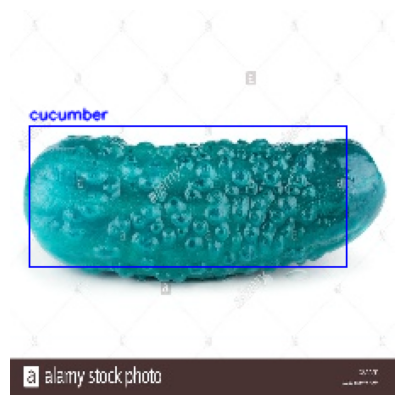

1/1 [==============================] - 0s 132ms/step


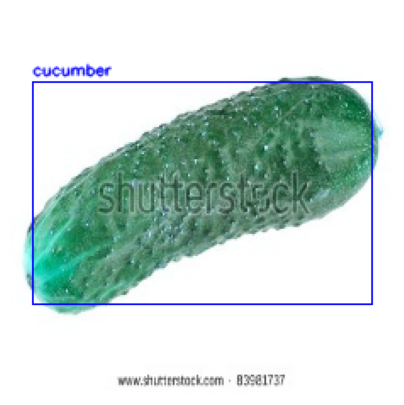

1/1 [==============================] - 0s 146ms/step


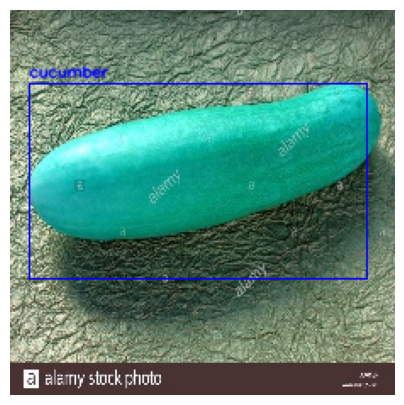

In [113]:
for i in range(1,5):
    path = f"/content/drive/MyDrive/obj_detection/training_images/cucumber_{i}.jpg"
    prediction(path, model)

1/1 [==============================] - 0s 217ms/step


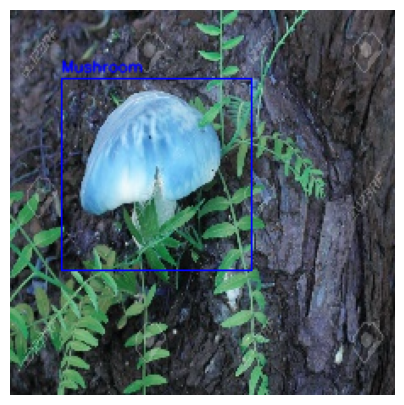

1/1 [==============================] - 0s 159ms/step


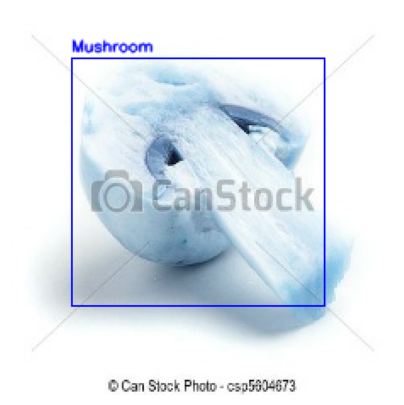

1/1 [==============================] - 0s 142ms/step


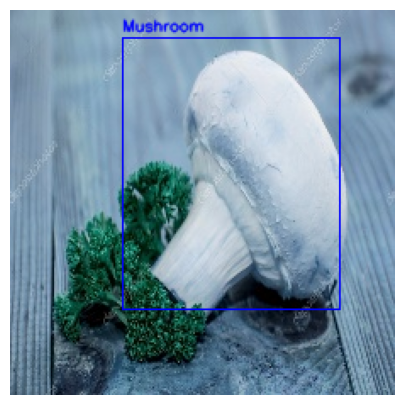

1/1 [==============================] - 0s 132ms/step


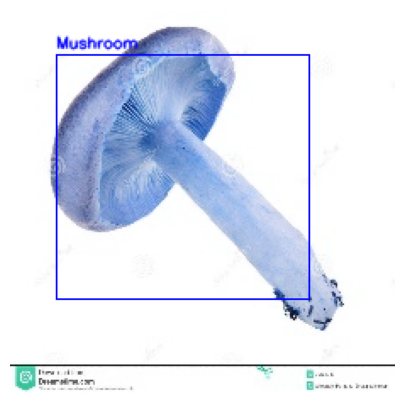

1/1 [==============================] - 0s 145ms/step


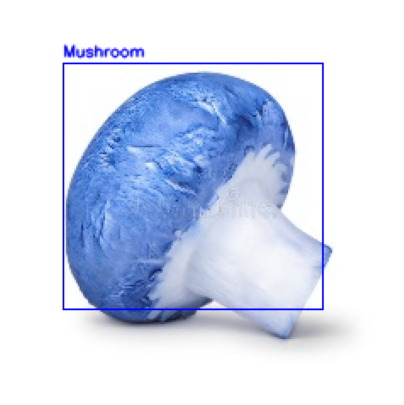

In [112]:
for i in range(10,15):
    path = f"/content/drive/MyDrive/obj_detection/training_images/mushroom_{i}.jpg"
    prediction(path, model)